# Predicting and simulating waveguide Bragg gratings

## Introduction

This notebook provides a guide to predicting and simulating a complete photonic device. It extends the [Bragg grating example](https://www.flexcompute.com/tidy3d/examples/notebooks/BraggGratings/) from [Tidy3D](https://www.flexcompute.com/tidy3d/), which is based on the reference cited below. Our tutorial is organized into the three following sections:
1. Conduct a nominal simulation of a waveguide Bragg grating, exactly as demonstrated in the Tidy3D example.
2. Predict and compare the structures using PreFab.
3. Simulate and evaluate the predicted performances using Tidy3D.

Reference:  `Xu Wang, Yun Wang, Jonas Flueckiger, Richard Bojko, Amy Liu, Adam Reid, James Pond, Nicolas A. F. Jaeger, and Lukas Chrostowski, "Precise control of the coupling coefficient through destructive interference in silicon waveguide Bragg gratings," Opt. Lett. 39, 5519-5522 (2014)`, DOI: [10.1364/OL.39.005519](https://doi.org/10.1364/OL.39.005519).

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tidy3d as td

import prefab as pf

## Nominal simulation

First, the geometry of the structure is defined. Both waveguides are set up in the same simulation side-by-side.

In [2]:
# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# geometric parameters
wg_height = 0.22
wg_feed_length = 0.75
wg_feed_width = 0.5
corrug_width = 0.05
num_periods = 100
period = 0.324

shift = period / 2
corrug_length = period / 2
wg_length = num_periods * period
wg_width = wg_feed_width - corrug_width

wavelength0 = 1.532
freq0 = td.C_0 / wavelength0
fwidth = freq0 / 40.0
run_time = 5.0e-12
wavelength_min = td.C_0 / (freq0 + fwidth)

# place the two waveguides with their centres half a free-space wavelength apart
wg1_y = wavelength0 / 2
wg2_y = -wavelength0 / 2

# waveguide 1
wg1_size = [td.inf, wg_width, wg_height]
wg1_center = [0, wg1_y, wg_height / 2]
wg1_medium = Si

# waveguide 2
wg2_size = [td.inf, wg_width, wg_height]
wg2_center = [0, wg2_y, wg_height / 2]
wg2_medium = Si

# corrugation setup for waveguide 1
cg1_size = [corrug_length, corrug_width, wg_height]
cg1_center_plus = [
    -wg_length / 2 + corrug_length / 2,
    wg_width / 2 + corrug_width / 2 + wg1_y,
    wg_height / 2,
]
cg1_center_minus = [
    -wg_length / 2 + corrug_length / 2,
    -wg_width / 2 - corrug_width / 2 + wg1_y,
    wg_height / 2,
]
cg1_medium = Si

# corrugation setup for waveguide 2
cg2_size = [corrug_length, corrug_width, wg_height]
cg2_center_plus = [
    -wg_length / 2 + corrug_length / 2,
    wg_width / 2 + corrug_width / 2 + wg2_y,
    wg_height / 2,
]
cg2_center_minus = [
    -wg_length / 2 + corrug_length / 2 + shift,
    -wg_width / 2 - corrug_width / 2 + wg2_y,
    wg_height / 2,
]
cg2_medium = Si

# substrate
sub_size = [td.inf, td.inf, 2]
sub_center = [0, 0, -1.0]
sub_medium = SiO2

# create the substrate
substrate = td.Structure(
    geometry=td.Box(center=sub_center, size=sub_size),
    medium=sub_medium,
    name="substrate",
)

# create the first waveguide
waveguide_1 = td.Structure(
    geometry=td.Box(center=wg1_center, size=wg1_size),
    medium=wg1_medium,
    name="waveguide_1",
)

# create the second waveguide
waveguide_2 = td.Structure(
    geometry=td.Box(center=wg2_center, size=wg2_size),
    medium=wg2_medium,
    name="waveguide_2",
)

# create the corrugation for the first waveguide
corrug1_plus = []
corrug1_minus = []
for i in range(num_periods):
    # corrugation on the +y side
    center = cg1_center_plus
    if i > 0:
        center[0] += period
    plus = td.Structure(
        geometry=td.Box(center=center, size=cg1_size),
        medium=cg1_medium,
        name=f"corrug1_plus_{i}",
    )

    # corrugation on the -y side
    center = cg1_center_minus
    if i > 0:
        center[0] += period
    minus = td.Structure(
        geometry=td.Box(center=center, size=cg1_size),
        medium=cg1_medium,
        name=f"corrug1_minus_{i}",
    )

    corrug1_plus.append(plus)
    corrug1_minus.append(minus)

# create the corrugation for the second waveguide
corrug2_plus = []
corrug2_minus = []
for i in range(num_periods):
    # corrugation on the +y side
    center = cg2_center_plus
    if i > 0:
        center[0] += period
    plus = td.Structure(
        geometry=td.Box(center=center, size=cg2_size),
        medium=cg2_medium,
        name=f"corrug2_plus_{i}",
    )

    # corrugation on the -y side
    center = cg2_center_minus
    if i > 0:
        center[0] += period
    minus = td.Structure(
        geometry=td.Box(center=center, size=cg2_size),
        medium=cg2_medium,
        name=f"corrug2_minus_{i}",
    )

    corrug2_plus.append(plus)
    corrug2_minus.append(minus)

# full simulation domain
sim_size = [
    wg_length + wavelength0 * 1.5,
    2 * wavelength0 + wg_width + 2 * corrug_width,
    3.7,
]
sim_center = [0, 0, 0.0]

# boundary conditions - Bloch boundaries are used to emulate an infinitely long grating
boundary_spec = td.BoundarySpec(
    # x=td.Boundary.bloch(bloch_vec=num_periods/2),
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary.pml(),
)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20)

A mode source is defined for each waveguide.

In [3]:
# mode source for waveguide 1
source1_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth, amplitude=1)
mode_src1 = td.ModeSource(
    center=[-wg_length / 2 - period, wg1_y, wg_height / 2],
    size=[0, waveguide_1.geometry.size[1] * 2, waveguide_1.geometry.size[2] * 2],
    mode_index=0,
    direction="+",
    source_time=source1_time,
    mode_spec=td.ModeSpec(),
)

# mode source for waveguide 2
source2_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth, amplitude=1)
mode_src2 = td.ModeSource(
    center=[-wg_length / 2 - period, wg2_y, wg_height / 2],
    size=[0, waveguide_2.geometry.size[1] * 2, waveguide_2.geometry.size[2] * 2],
    mode_index=0,
    direction="+",
    source_time=source2_time,
    mode_spec=td.ModeSpec(),
)

To visualize the field distribution in the waveguides, a monitor is placed in the `xy` plane cutting through both waveguides. A pair of flux monitors is also placed on the far side the demonstrate the transmission and reflection characteristics.

In [4]:
# create monitors
monitor_xy = td.FieldMonitor(
    center=[0, 0, wg_height / 2],
    size=[wg_length, 2 * wavelength0 + wg_width + 2 * corrug_width, 0],
    freqs=[freq0],
    name="fields_xy",
)

freqs = np.linspace(freq0 - 2 * fwidth, freq0 + 2 * fwidth, 200)
monitor_flux_aligned = td.FluxMonitor(
    center=[wg_length / 2 + period, wg1_y, wg_height / 2],
    size=[0, waveguide_1.geometry.size[1] * 3, waveguide_1.geometry.size[2] * 5],
    freqs=freqs,
    name="flux_aligned",
)

monitor_flux_misaligned = td.FluxMonitor(
    center=[wg_length / 2 + period, wg2_y, wg_height / 2],
    size=[0, waveguide_2.geometry.size[1] * 3, waveguide_2.geometry.size[2] * 5],
    freqs=freqs,
    name="flux_misaligned",
)

All the structures, sources, and monitors are consolidated, and the simulation is created and visualized.

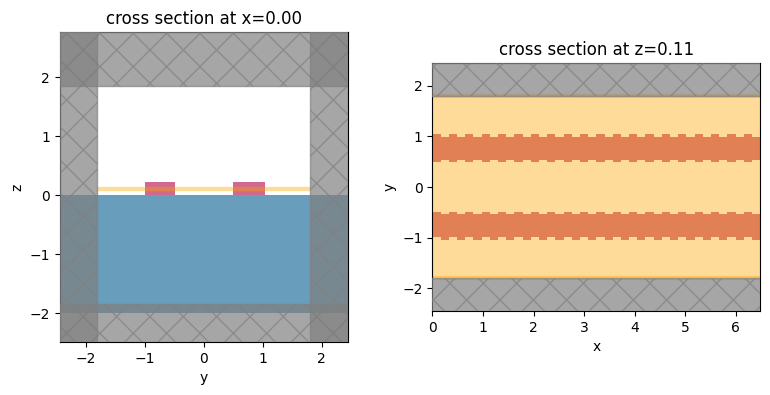

In [5]:
# list of all structures
structures = (
    [substrate, waveguide_1, waveguide_2]
    + corrug1_plus
    + corrug1_minus
    + corrug2_plus
    + corrug2_minus
)

# list of all sources
sources = [mode_src1, mode_src2]

# list of all monitors
monitors = [monitor_xy, monitor_flux_aligned, monitor_flux_misaligned]

# create the simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=grid_spec,
    structures=structures,
    sources=sources,
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
)

# plot the simulation domain
f, (ax1, ax3) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim.plot(x=0, ax=ax1)
sim.plot(z=wg_height / 2, ax=ax3)
ax3.set_xlim(0, 20 * period)
plt.show()

In [6]:
# run simulation
import tidy3d.web as web

sim_data = web.run(sim, task_name="bragg", path="data/bragg.hdf5", verbose=True)

15:19:44 EST Created task 'bragg' with task_id                                  
             'fdve-89aed5d1-dd5c-437d-b5a2-c59c5bf38464' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=13422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89aed5d1-dd5c-437d-b5a2-c59c5bf38464\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=931483;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89aed5d1-dd5c-437d-b5a2-c59c5bf38464\taskId]8;;\]8;id=13422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89aed5d1-dd5c-437d-b5a2-c59c5bf38464\=]8;;\]8;id=687249;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89aed5d1-dd5c-437d-b5a2-c59c5bf38464\fdve]8;;\]8;id=13422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89aed5d1-dd5c-437d-b5a2-c59c5bf38464\-89aed5d1-dd5]8;;\
             ]8;id=13422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89aed5d1-dd5c-437d-b5a2-c59c5bf38464\c-437d-b5a2-c59c5bf38464']8;;\.

Output()

15:19:48 EST status = success

Output()

15:19:52 EST loading simulation from data/bragg.hdf5

The frequency-domain fields are plotted in the `xy` plane cutting through the waveguides. We notice that the grating with aligned corrugation effectively reflects power at the design frequency, while the misalignment in the second grating causes it to be mostly transmissive.

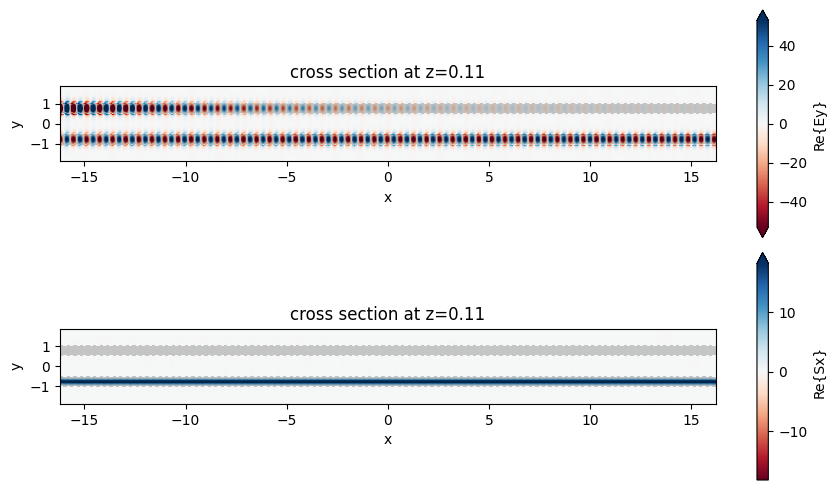

In [7]:
# plot fields on the monitor
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(9, 5))
sim_data.plot_field(
    field_monitor_name="fields_xy", field_name="Ey", val="real", f=freq0, ax=ax[0]
)
sim_data.plot_field(
    field_monitor_name="fields_xy", field_name="Sx", val="real", f=freq0, ax=ax[1]
)
plt.show()

The observations made in the field plot above can be confirmed by plotting the flux recorded by the flux monitors as a function of frequency. In the region of the design frequency, indicated by the dashed black line, the drop in flux for the aligned-corrugation grating confirms its reflective property. 

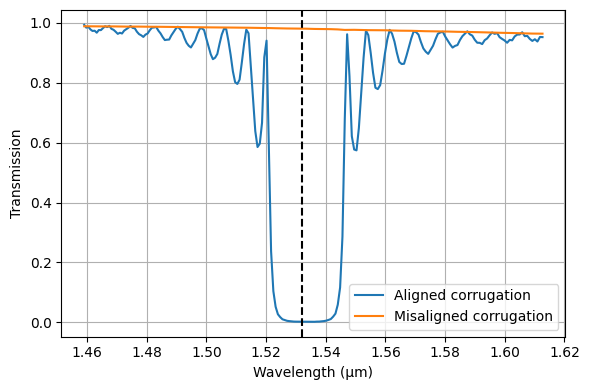

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

# plot transmitted flux for each waveguide
ax.plot(td.C_0 / freqs, sim_data["flux_aligned"].flux, label="Aligned corrugation")
ax.plot(
    td.C_0 / freqs, sim_data["flux_misaligned"].flux, label="Misaligned corrugation"
)

# vertical line at design frequency
ax.axvline(td.C_0 / freq0, ls="--", color="k")

ax.set(xlabel="Wavelength (µm)", ylabel="Transmission")

ax.grid(True)
plt.legend()
plt.show()

## PreFab prediction

To convert Tidy3D structures into a PreFab `Device`, we can use `prefab.read.from_tidy3d`. However, we'll take a detailed approach to help you understand the underlying process.

We include a small buffer region around the structures to prevent rounding off the input/output interfaces, as these will likely connect to other devices and we want to avoid unnecessary scattering.

<Axes: xlabel='x (nm)', ylabel='y (nm)'>

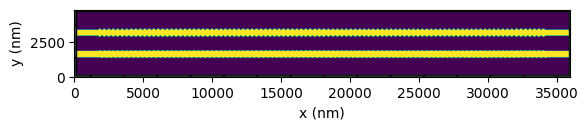

In [9]:
prediction_buffer_width = 0.5
X = np.arange(
    sim.bounds[0][0] - prediction_buffer_width,
    sim.bounds[1][0] + prediction_buffer_width,
    0.001,
)
Y = np.arange(
    sim.bounds[0][1] - prediction_buffer_width,
    sim.bounds[1][1] + prediction_buffer_width,
    0.001,
)
Z = np.array([wg_height / 2])
grid = td.Grid(boundaries=td.Coords(x=X, y=Y, z=Z))
eps = np.real(sim.epsilon_on_grid(grid=grid, coord_key="boundaries", freq=freq0).values)
device_array = pf.geometry.binarize_hard(device_array=eps, eta=Si.permittivity - 0.1)[
    :, :, 0
]
device_array = np.rot90(device_array, k=1)

device = pf.Device(device_array=device_array)
device.plot()

With the device defined and formatted for PreFab, we can now predict it. We use the `ANT_NanoSOI` model of [Applied Nanotools](https://www.appliednt.com/) for this prediction.

> **Note:** If you would like to see models of other fabrication processes, please contact us at [support@prefabphotonics.com](mailto:support@prefabphotonics.com) to request them. Current models are listed [here](https://docs.prefabphotonics.com/models/).

We set `gpu=True` to speed up the prediction. Note that GPU predictions have a longer startup time, so smaller devices will run faster on the CPU (`gpu=False`). We set `binarize=True` to capture the most likely fabrication outcome, but we can also set `binarize=False` to get the full range of possible outcomes (more on this in a future notebook about prediction uncertainty and fabrication variability).

Prediction: 100%|██████████████████████████████| 100/100 [00:20<00:00,  4.85%/s]


<Axes: xlabel='x (nm)', ylabel='y (nm)'>

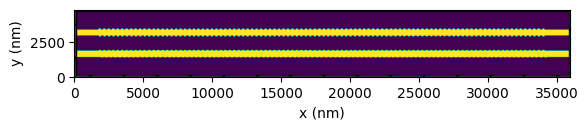

In [10]:
prediction = device.predict(model=pf.models["ANT_NanoSOI"], binarize=True, gpu=True)
prediction.plot()

Now convert the predicted device back to a Tidy3D structure with [gdstk](https://github.com/heitzmann/gdstk) as an intermediate layer.

> **Note:** We also extend the run time of the simulation to 10 ps to account for the additional time required for the fields to decay.


Creating cell 'bragg_p'...


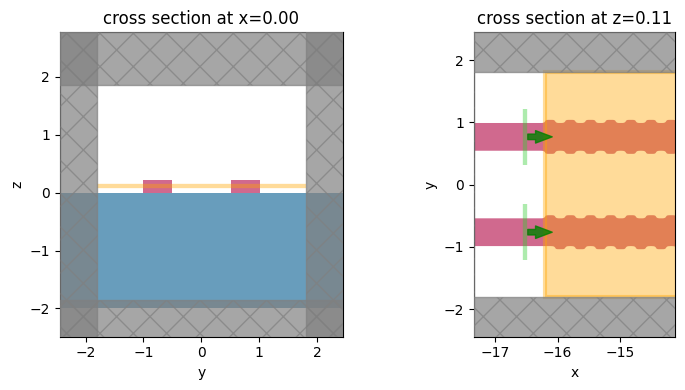

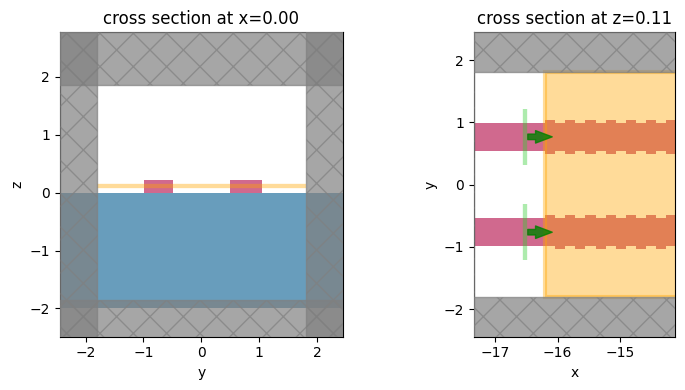

In [11]:
prediction_cell = prediction.to_gdstk(
    cell_name="bragg_p", origin=(sim.center[0], sim.center[1])
)

bragg_p = td.Structure(
    geometry=td.Geometry.from_gds(
        gds_cell=prediction_cell,
        axis=2,
        slab_bounds=(0, wg_height),
        gds_layer=1,
        gds_dtype=0,
    ),
    medium=Si,
)

sim_p = sim.copy(update=dict(structures=[substrate, bragg_p], run_time=10.0e-12))

# plot the predicted structure
f, (ax1, ax3) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim_p.plot(x=0, ax=ax1)
sim_p.plot(z=wg_height / 2, ax=ax3)
ax3.set_xlim(sim_p.bounds[0][0], sim_p.bounds[0][0] + 10 * period)
plt.show()

# plot the nominal structure
f, (ax1, ax3) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim.plot(x=0, ax=ax1)
sim.plot(z=wg_height / 2, ax=ax3)
ax3.set_xlim(sim.bounds[0][0], sim.bounds[0][0] + 10 * period)
plt.show()

Plotting the predicted and nominal structures side by side, we can see that the predicted structure undergoes significant corner rounding.

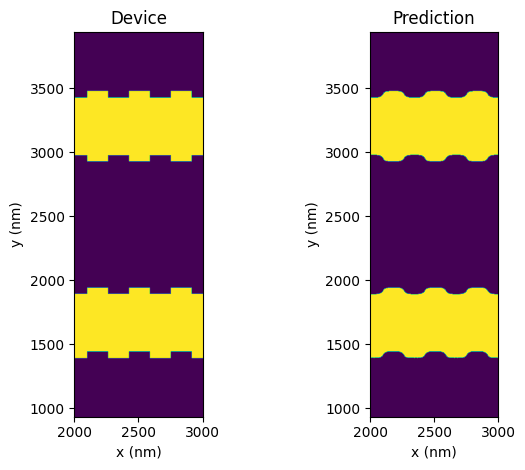

In [12]:
bounds = (
    (2000, int(device.shape[0] / 2) - 1500),
    (3000, int(device.shape[0] / 2) + 1500),
)

fig, axes = plt.subplots(1, 2, tight_layout=True)
device.plot(bounds=bounds, ax=axes[0])
axes[0].set_title("Device")
prediction.plot(bounds=bounds, ax=axes[1])
axes[1].set_title("Prediction")
plt.show()

## Simulation of predicted device

Let's now simulate the predicted device and compare the results to the nominal simulation.

In [13]:
# run simulation
import tidy3d.web as web

sim_data_p = web.run(sim_p, task_name="bragg_p", path="data/bragg_p.hdf5", verbose=True)

15:20:49 EST Created task 'bragg_p' with task_id                                
             'fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=490779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=177597;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\taskId]8;;\]8;id=490779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\=]8;;\]8;id=327514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\fdve]8;;\]8;id=490779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\-45f7ae2b-1b7]8;;\
             ]8;id=490779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\a-4f0c-a909-068c27a98578']8;;\.

Output()

15:20:59 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:21:05 EST status = preprocess

15:21:09 EST Maximum FlexCredit cost: 1.663. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

15:23:16 EST early shutoff detected at 72%, exiting.

15:23:17 EST status = postprocess

Output()

15:23:19 EST status = success

             View simulation result at                                          
             ]8;id=696537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=40423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\taskId]8;;\]8;id=696537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\=]8;;\]8;id=925890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\fdve]8;;\]8;id=696537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\-45f7ae2b-1b7]8;;\
             ]8;id=696537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45f7ae2b-1b7a-4f0c-a909-068c27a98578\a-4f0c-a909-068c27a98578']8;;\.

Output()

15:23:25 EST loading simulation from data/bragg_p.hdf5

The predicted device exhibits a broader reflection window compared to the nominal device, primarily due to the rounding of the corrugation corners. Additionally, there is a slight shift in the center of the reflection peak.

In a real device, other factors such as sidewall roughness, thickness variations, and slanted sidewalls can contribute to further losses. These factors can also be incorporated into the analysis to provide a more comprehensive understanding of performance degradation resulting from the fabrication process, particularly lithography.

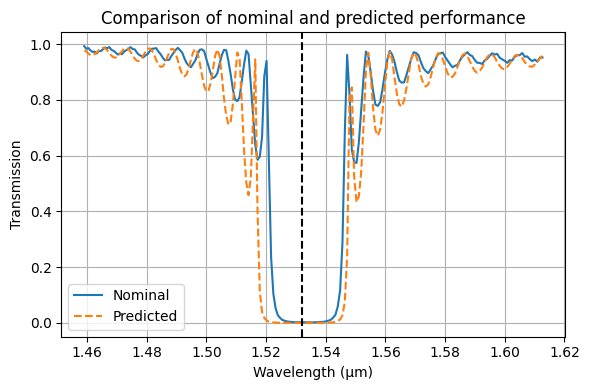

In [14]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

# plot transmitted flux for each waveguide
ax.plot(td.C_0 / freqs, sim_data["flux_aligned"].flux, label="Nominal", ls="-")
ax.plot(td.C_0 / freqs, sim_data_p["flux_aligned"].flux, label="Predicted", ls="--")

# vertical line at design frequency
ax.axvline(td.C_0 / freq0, ls="--", color="k")

ax.set(
    xlabel="Wavelength (µm)",
    ylabel="Transmission",
    title="Comparison of nominal and predicted performance",
)

ax.grid(True)
plt.legend()
plt.show()

The process of predicting and simulating a photonic device is straightforward and adaptable to various designs and simulation scenarios. The key steps involve converting device designs into a format compatible with PreFab, using a selected fabrication model to predict the device, and then converting the predicted device back into the simulation domain for re-simulation.

We encourage you to apply this process to your own devices!